# Option pricing

This notebook presents different methods to calculate option prices, as well as Greeks calculation and work on implied volatility. \
For the moment, it only supports European and American options. 

In [67]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin, root
import pandas as pd

In [2]:
St=100
K=100
T=1.
t=0
r=.05
q=0.
sigma=.2

### Black-Scholes
$$C(S_t, t) = N(d_+)S_t e^{-q(T-t)}-N(d_-)Ke^{-r(T-t)}$$
$$d_+ = \frac{1}{\sigma\sqrt{T-t}}\left[\ln\left(\frac{S_t}{K}\right)+\left(r-q+\frac{\sigma^2}{2}\right)(T-t)\right] $$
$$     d_- = d_+-\sigma\sqrt{T-t} $$

In [3]:
def Black_Scholes(call_put, sigma, K, T, t, St, r ,q):
    """Calculate the Black-Scholes price of a call or put option"""
    d_plus = (np.log(St/K)+(r-q+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d_minus = d_plus-sigma*np.sqrt(T-t)
    if(call_put=="call"):
        return norm.cdf(d_plus)*St*np.exp(-q*(T-t))- norm.cdf(d_minus)*K*np.exp(-r*(T-t))
    elif(call_put=="put"):
        return -norm.cdf(-d_plus)*St*np.exp(-q*(T-t))+ norm.cdf(-d_minus)*K*np.exp(-r*(T-t))
    else:
        raise ValueError("Please choose between call and put")

In [4]:
print("Black-Scholes call price: ",Black_Scholes("call", sigma, K, T, t, St, r, q))
print("Black-Scholes put price: ",Black_Scholes("put", sigma, K, T, t, St, r, q))

Black-Scholes call price:  10.450583572185572
Black-Scholes put price:  5.573526022256971


### Monte-Carlo simulation

In [5]:
def Monte_Carlo(call_put, sigma, K, T, t, St, r, q):
    """Calculate option price using Monte Carlo simulation"""
    n=10 #Number of time points
    dt=(T-t)/(n-1)
    N=50000 #Number of paths
    S=np.zeros((N,n))
    z=np.random.normal(0,1,(N,n))

    S[:,0]=St #Initialise all the paths at St at time t

    for j in range(1,n):
        S[:,j]=S[:,j-1]*np.exp((r-q-sigma**2/2)*dt+sigma*np.sqrt(dt)*z[:,j])    #compute the next time point for all paths

    if(call_put=="call"):
        return np.mean(np.max((S[:,n-1]-K,np.zeros(N)), axis=0))*np.exp(-r*(T-t))   #Take the average discounted payoff
    elif(call_put=="put"):
        return np.mean(np.max((K-S[:,n-1],np.zeros(N)), axis=0))*np.exp(-r*(T-t))
    else:
        raise ValueError("Please choose between call and put")

In [7]:
print("Monte-Carlo call price: ",Monte_Carlo("call", sigma, K, T, t, St, r, q))
print("Monte-Carlo put price: ",Monte_Carlo("put", sigma, K, T, t, St, r, q))

Monte-Carlo call price:  10.461216628966866
Monte-Carlo put price:  5.593500372697987


We see that the prices from the Monte Carlo simulation are similar to the ones obtained with the Black-Scholes formulas but move by a couple cents between iterations.

### Tree

In [8]:
def Tree(call_put, am_eu, sigma, K, T, t, St, r, q):
    """Calculate option price using binomial tree"""
    n = 400  # Number of time periods
    dt = (T-t) / n
    S = np.zeros((n,n+1))
    U = np.exp(sigma*np.sqrt(dt))
    D = 1 / U

    S[0,0] = St

    # Compute the stock prices at each time point
    # the tree recombines so there is exactly i+1 nodes after the ith time period
    for i in range(n-1):
        S[i+1,:i+1] = S[i,:i+1]*U   # the three recombines so all the i+1 nodes are created by taking the up of all previous nodes
        S[i+1][i+1] = S[i][i]*D     # except the last node that must be created by multiplying the last node of the previous time period by the down factor

    prices = np.zeros((n,n+1))
    if call_put == "call":
        prices[n-1,:] = np.max((S[n-1,:]-K, np.zeros(n+1)), axis=0) # Payoff at maturity
    elif call_put == "put":
        prices[n-1,:] = np.max((K-S[n-1,:], np.zeros(n+1)), axis=0)
    else:
        raise ValueError("Please choose between call and put")

    p = (np.exp((r-q)*dt)-D)/(U-D)  # Risk-neutral probability
    if am_eu == "European":
        for i in range(n-2, -1, -1):
            for j in range(i+1):
                prices[i,j] = (p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt)   # Backward computation of option prices
    elif am_eu == "American":
        if call_put == "call":
            for i in range(n-2, -1, -1):
                for j in range(i+1):
                    prices[i,j] = np.maximum((p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt), S[i,j]-K) # Adjustment for early exercise
        elif call_put == "put":
            for i in range(n-2, -1, -1):
                for j in range(i+1):
                    prices[i,j] = np.maximum((p*prices[i+1,j] + (1-p)*prices[i+1,j+1])*np.exp(-r*dt), K-S[i,j])
        else:
            raise ValueError("Please choose American or European.")

    return prices[0,0]

In [9]:
print("Binomial tree European call price: ", Tree("call", "European", sigma, K, T, t, St, r, q))
print("Binomial tree European put price: ", Tree("put", "European", sigma, K, T, t, St, r, q))

print("Binomial tree American call price: ", Tree("call", "American", sigma, K, T, t, St, r, q))
print("Binomial tree American put price: ", Tree("put", "American", sigma, K, T, t, St, r, q))

Binomial tree European call price:  10.43893173730427
Binomial tree European put price:  5.573765298364829
Binomial tree American call price:  10.43893173730427
Binomial tree American put price:  6.088405897039062


Once again, the prices of European options are similar to Monte Carlo and Black-Scholes prices.

### Partial differential equation (finite-difference method)

$$\frac{\partial V}{\partial t}+\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}+ (r-q)S\frac{\partial V}{\partial S}- rV = 0$$
$$\Theta+\frac{1}{2}\sigma^2 S^2 \Gamma+ (r-q)S \Delta- rV = 0$$
We can discretize the Greeks (I choose to use the explicit method, ie backward approximation for $\Theta$, central approximation for $\Delta$ and standard approximation for $\Gamma$):
$$\Theta =\frac{\partial V}{\partial t} = \frac{V(t_i,S_j)-V(t_{i-1},S_j)}{\delta t}$$
$$\Gamma =\frac{\partial^2 V}{\partial S^2}= \frac{V(t_i,S_{j+1})-2V(t_i,S_j)+V(t_i,S_{j-1})}{(\delta S)^2}$$
$$ \Delta =\frac{\partial V}{\partial S}= \frac{V(t_i,S_{j+1})-V(t_i,S_{j-1})}{2\delta S}$$
Thus, we have:
$$V(t_{i-1},S_j)=(1-r \delta t) V(t_i,S_j)+\frac{1}{2}\sigma^2 \delta t S_j^2 \frac{V(t_i,S_{j+1})+2V(t_i,S_j)+V(t_i,S_{j-1})}{(\delta S)^2}+(r-q) \delta t S_j \frac{V(t_i,S_{j+1})-V(t_i,S_{j-1})}{2\delta S}$$
$$V(t_{i-1},S_j)= a_j V(t_i,S_{j-1})+b_j V(t_i, S_j)+c_j V(t_i, S_{j+1})$$
with $a_j=\frac{1}{2} \delta t (\sigma^2 j^2-(r-q)j) $, $b_j=1-\delta t (\sigma^2 j^2 +r)$ and $c_j=\frac{1}{2} \delta t (\sigma^2 j^2+(r-q)j)$ using $S_j=j \delta S$.

We set boundaries conditions:
$$ \forall i, V(t_i,0) = 0 $$
$$ \forall i, V(t_i, S_j) \underset{S_j \rightarrow \infty}{\sim} S_j-K e^{-r(T-t_i)}$$
$$ \forall j, V(T, S_j) = \max(S_j-K, 0)$$

In [10]:
def PDE(call_put, am_eu, sigma, K, T, St, r, q):
    """Calculate option price using finite difference method"""
    S_max = St*(1+2*sigma*np.sqrt(T))  
    n_t = 1000  # Number of time points
    n_S = 50  # Number of price points
    dt = T/(n_t-1)
    dS = S_max/(n_S-1)
    V = np.zeros((n_t,n_S))

    # Stability check
    if dt*sigma*sigma*n_S*n_S > 1:
        print("Change the parameters in order to assure the stability.")

    # Initial and boundary conditions
    if call_put == "call":
        for i in range(n_t):
            V[i,n_S-1] = S_max-K*np.exp(-r*(T-i*dt))    
        for j in range(n_S):
            V[n_t-1,j] = np.max((j*dS-K, 0))
    elif call_put == "put":
        for i in range(n_t):
            V[i,0] = K*np.exp(-r*(T-i*dt))
        for j in range(n_S):
            V[n_t-1,j] = np.max((K-j*dS, 0))
    else:
        raise ValueError("Please choose between call and put")

    # Backward computation of option prices
    if am_eu=="European":
        for i in range(n_t-1, 0, -1):
            for j in range(1, n_S-1):
                a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                b = 1-dt*(sigma**2*j**2+r)
                c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                V[i-1,j] = a*V[i,j-1]+b*V[i,j]+c*V[i,j+1]
    elif am_eu=="American":
        if call_put=="call":
            for i in range(n_t-1, 0, -1):
                for j in range(1, n_S-1):
                    a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                    b = 1-dt*(sigma**2*j**2+r)
                    c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                    V[i-1,j] = np.max((a*V[i,j-1]+b*V[i,j]+c*V[i,j+1], j*dS-K))
        elif call_put=="put":
            for i in range(n_t-1, 0, -1):
                for j in range(1, n_S-1):
                    a = 0.5*dt*(sigma**2*j**2-(r-q)*j)
                    b = 1-dt*(sigma**2*j**2+r)
                    c = 0.5*dt*(sigma**2*j**2+(r-q)*j)
                    V[i-1,j] = np.max((a*V[i,j-1]+b*V[i,j]+c*V[i,j+1], K-j*dS))
    else:
        raise ValueError("Please choose between American and European")

    return V[0,round(St/dS)]


In [11]:
print("PDE European call price: ", PDE("call", "European", sigma, K, T, St, r, q))
print("PDE European put price: ", PDE("put", "European", sigma, K, T, St, r, q))
print("PDE American call price: ", PDE("call", "American", sigma, K, T, St, r, q))
print("PDE American put price: ", PDE("put", "American", sigma, K, T, St, r, q))

PDE European call price:  10.429676699644343
PDE European put price:  5.552504457957342
PDE American call price:  10.429676699644343
PDE American put price:  6.066934390827328


The differences with the previous methods are limited.

### Comparison between methods

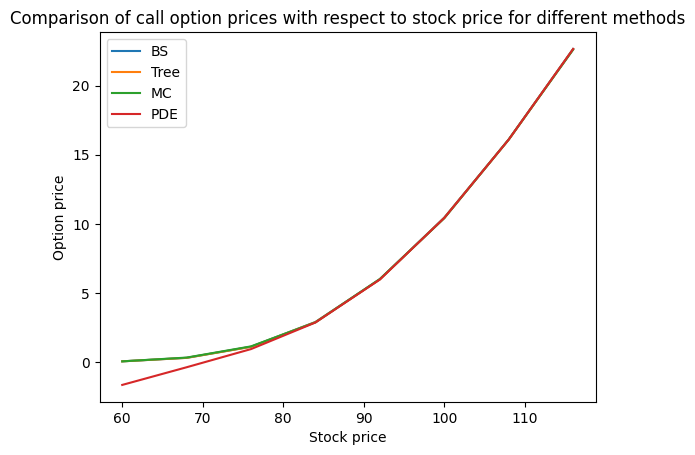

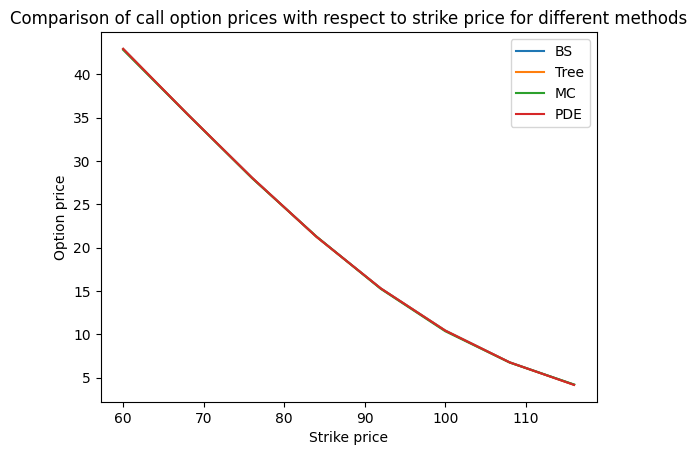

In [12]:
S = np.arange(60,120,8)
prices_BS = Black_Scholes("call", sigma, K, T, t, S, r,q)
prices_tree = [Tree("call", "European", sigma, K, T, t, St, r, q) for St in S]
prices_MC = [Monte_Carlo("call", sigma, K, T, t, St, r, q) for St in S]
prices_PDE = [PDE("call", "European", sigma, K, T, St, r, q) for St in S]

plt.plot(S, prices_BS, label="BS")
plt.plot(S, prices_tree, label="Tree")
plt.plot(S, prices_MC, label="MC")
plt.plot(S, prices_PDE, label="PDE")
plt.xlabel("Stock price")
plt.ylabel("Option price")
plt.title("Comparison of call option prices with respect to stock price for different valuation methods")
plt.legend()
plt.show()

St=100
Ks = np.arange(60,120,8)
prices_BS = Black_Scholes("call", sigma, Ks, T, t, St, r,q)
prices_tree = [Tree("call", "European", sigma, K, T, t, St, r, q) for K in Ks]
prices_MC = [Monte_Carlo("call", sigma, K, T, t, St, r, q) for K in Ks]
prices_PDE = [PDE("call", "European", sigma, K, T, St, r, q) for K in Ks]

plt.plot(S, prices_BS, label="BS")
plt.plot(S, prices_tree, label="Tree")
plt.plot(S, prices_MC, label="MC")
plt.plot(S, prices_PDE, label="PDE")
plt.xlabel("Strike price")
plt.ylabel("Option price")
plt.title("Comparison of call option prices with respect to strike price for different valuation methods")
plt.legend()
plt.show()

## Greeks

### Delta
$$\Delta = \frac{\partial V}{\partial S}$$

In [13]:
def delta_BS(call_put, sigma, K, T, t, St, r, q):
    """Compute the delta of a call or put option using the Black-Scholes formula."""
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    if call_put == "call":
        return norm.cdf(d_plus, 0, 1)*np.exp(-q*(T-t))
    elif call_put == "put":
        return -norm.cdf(-d_plus, 0, 1)*np.exp(-q*(T-t))
    else:
        raise ValueError("Please choose between call and put")
    
def delta_num(call_put, am_eu, sigma, K, T, t, St, r, q, dS=.01):
    """Compute the delta of a call or put option using numerical differentiation (central difference) using the binomial tree method."""
    return (Tree(call_put, am_eu, sigma, K, T, t, St+dS, r, q)-Tree(call_put, am_eu, sigma, K, T, t, St-dS, r, q))/(2*dS)

In [15]:
print("Delta BS European call price: ", delta_BS("call", sigma, K, T, t, St, r, q))
print("Delta BS European put price: ", delta_BS("put", sigma, K, T, t, St, r, q))

print("Delta numerical European tree call price: ", delta_num("call", "European", sigma, K, T, t, St, r, q))
print("PDE numerical European tree put price: ", delta_num("put", "European", sigma, K, T, t, St, r, q))

print("Delta numerical American tree call price: ", delta_num("call", "American", sigma, K, T, t, St, r, q))
print("PDE numerical American tree put price: ", delta_num("put", "American", sigma, K, T, t, St, r, q))

Delta BS European call price:  0.6368306511756191
Delta BS European put price:  -0.3631693488243809
Delta numerical European tree call price:  0.6367509069479027
PDE numerical European tree put price:  -0.3632490930397303
Delta numerical American tree call price:  0.6367509069479027
PDE numerical American tree put price:  -0.4102546014949304


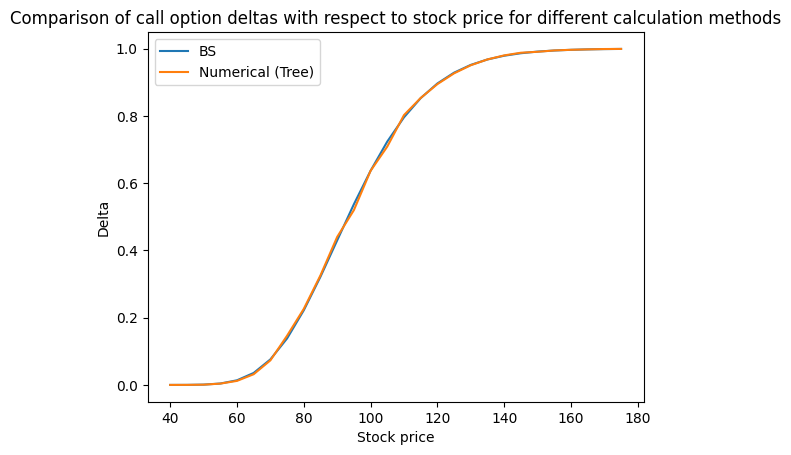

In [16]:
S = np.arange(40,180,5)
deltas_BS = delta_BS("call", sigma, K, T, t, S, r,q)
deltas_num = [delta_num("call", "European", sigma, K, T, t, St, r,q) for St in S]

plt.plot(S, deltas_BS, label="BS")
plt.plot(S, deltas_num, label="Numerical (Tree)")
plt.xlabel("Stock price")
plt.ylabel("Delta")
plt.title("Comparison of call option deltas with respect to stock price for different calculation methods")
plt.legend()

### Gamma

$$\Gamma = \frac{\partial^2 C}{\partial S^2}$$

In [17]:
def gamma_BS(call_put, sigma, K, T, t, St, r, q):
    """Compute the gamma of a call or put option using the Black-Scholes formula."""
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return norm.pdf(d_plus, 0, 1)*np.exp(-q*(T-t))/(St*sigma*np.sqrt(T-t))
    
def gamma_num(call_put, am_eu, sigma, K, T, t, St, r, q, dS=1e-5, method="tree"):
    """Compute the gamma of a call or put option using numerical differentiation using either the Black-Scholes formula or the binomial tree method for the valuation."""
    if method=="BS":
        return (Black_Scholes(call_put, sigma, K, T, t, St+dS, r, q)-2*Black_Scholes(call_put, sigma, K, T, t, St, r, q)+Black_Scholes(call_put, sigma, K, T, t, St-dS, r, q))/(dS**2)
    elif method=="tree":
        return (Tree(call_put, am_eu, sigma, K, T, t, St+dS, r, q)-2*Tree(call_put, am_eu, sigma, K, T, t, St, r, q)+Tree(call_put, am_eu, sigma, K, T, t, St-dS, r, q))/(dS**2)
    else:
        raise ValueError("Please choose between BS and tree")

In [18]:
print("Gamma BS European: ", gamma_BS("call", sigma, K, T, t, St, r, q))
print("Gamma numerical European tree: ", gamma_num("call", "European", sigma, K, T, t, St, r, q))
print("Gamma numerical American tree: ", gamma_num("call", "American", sigma, K, T, t, St, r, q))

Gamma BS European:  0.018762017345846895


Gamma numerical European tree:  8.881784197001251e-05
Gamma numerical American tree:  8.881784197001251e-05


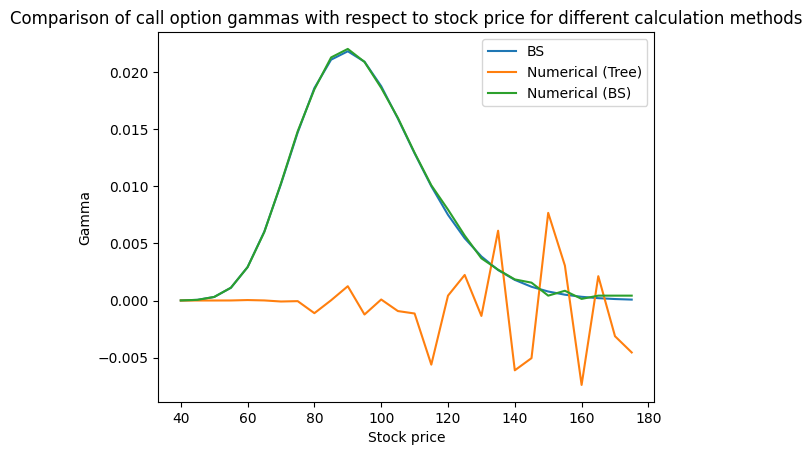

In [19]:
S = np.arange(40,180,5)
gammas_BS = gamma_BS("call", sigma, K, T, t, S, r,q)
gammas_num_tree = [gamma_num("call", "European", sigma, K, T, t, St, r, q, method="tree") for St in S]
gammas_num_BS = gamma_num("call", "European", sigma, K, T, t, S, r, q, method="BS")

plt.plot(S, gammas_BS, label="BS")
plt.plot(S, gammas_num_tree, label="Numerical (Tree)")
plt.plot(S, gammas_num_BS, label="Numerical (BS)")
plt.xlabel("Stock price")
plt.ylabel("Gamma")
plt.title("Comparison of call option gammas with respect to stock price for different calculation methods")
plt.legend()

We see on this chart that our binomial method does not give an appropriate gamma.

### Vega

$$ \nu = \frac{\partial V}{\partial \sigma} $$

In [20]:
def vega_BS(call_put, sigma, K, T, t, St, r, q):
    """Compute the vega of a call or put option using the Black-Scholes formula"""
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    return norm.pdf(d_plus, 0, 1)*St*np.sqrt(T-t)*np.exp(-q*(T-t))
    
def vega_num(call_put, am_eu, sigma, K, T, t, St, r, q, ds=1e-5):
    """Compute the vega of a call or put option using numerical differentiation (central difference) using the binomial tree method."""
    return (Tree(call_put, am_eu, sigma+ds, K, T, t, St, r, q)-Tree(call_put, am_eu, sigma-ds, K, T, t, St, r, q))/(2*ds)

In [21]:
print("Vega BS European: ", vega_BS("call", sigma, K, T, t, St, r, q))
print("Vega numerical European tree: ", vega_num("call", "European", sigma, K, T, t, St, r, q))
print("Vega numerical American tree: ", vega_num("call", "American", sigma, K, T, t, St, r, q))

Vega BS European:  37.52403469169379
Vega numerical European tree:  37.508713110767644
Vega numerical American tree:  37.508713110767644


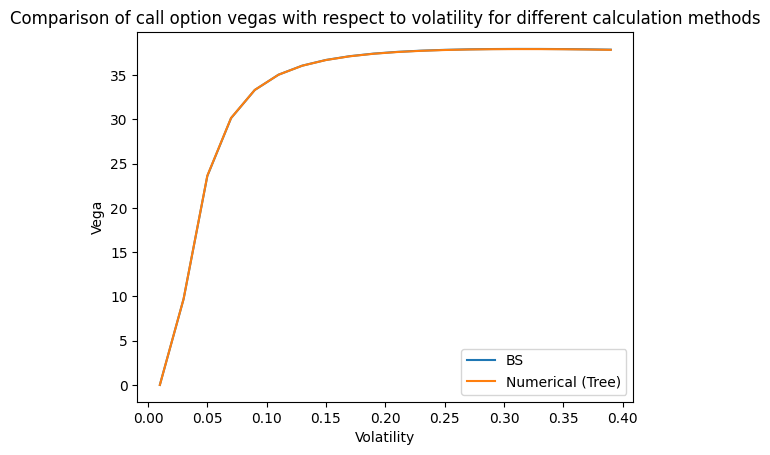

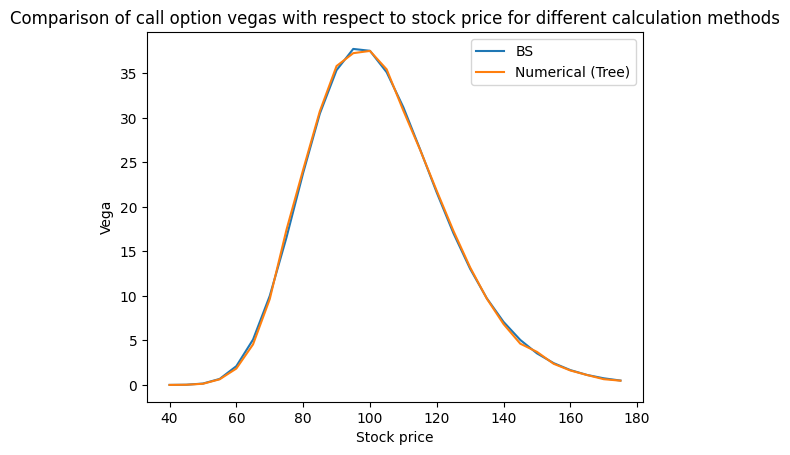

In [25]:
sigmas = np.arange(0.01,.4,.02)
vegas_BS = vega_BS("call", sigmas, K, T, t, St, r,q)
vegas_num = [vega_num("call", "European", sigma, K, T, t, St, r,q) for sigma in sigmas]

plt.plot(sigmas, vegas_BS, label="BS")
plt.plot(sigmas, vegas_num, label="Numerical (Tree)")
plt.xlabel("Volatility")
plt.ylabel("Vega")
plt.title("Comparison of call option vegas with respect to volatility for different calculation methods")
plt.legend()
plt.show()

S = np.arange(40,180,5)
vegas_BS = vega_BS("call", sigma, K, T, t, S, r,q)
vegas_num = [vega_num("call", "European", sigma, K, T, t, St, r,q) for St in S]

plt.plot(S, vegas_BS, label="BS")
plt.plot(S, vegas_num, label="Numerical (Tree)")
plt.xlabel("Stock price")
plt.ylabel("Vega")
plt.title("Comparison of call option vegas with respect to stock price for different calculation methods")
plt.legend()
plt.show()

### Theta

$$\Theta = -\frac{\partial V}{\partial t}$$

In [23]:
def theta_BS(call_put, sigma, K, T, t, St, r, q):
    """Compute the theta of a call or put option using the Black-Scholes formula."""
    d_plus = (np.log(St/K) + (r-q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d_minus = d_plus- sigma*np.sqrt(T-t) 
    if call_put == "call":
        return -np.exp(-q*(T-t))*St*norm.pdf(d_plus,0,1)*sigma/(2*np.sqrt(T-t))-r*K*np.exp(-r*(T-t))*norm.cdf(d_minus,0,1)+q*St*np.exp(-q*(T-t))*norm.cdf(d_plus,0,1)
    elif call_put == "put":
        return -np.exp(-q*(T-t))*St*norm.pdf(d_plus,0,1)*sigma/(2*np.sqrt(T-t))+r*K*np.exp(-r*(T-t))*norm.cdf(-d_minus,0,1)-q*St*np.exp(-q*(T-t))*norm.cdf(-d_plus,0,1)
    else:
        raise ValueError("Please choose between call and put")
    
def theta_num(call_put, am_eu, sigma, K, T, t, St, r, q, dt=.01):
    """Compute the theta of a call or put option using numerical differentiation (central difference) using the binomial tree method."""
    return (Tree(call_put, am_eu, sigma, K, T, t+dt, St, r, q)-Tree(call_put, am_eu, sigma, K, T, t-dt, St, r, q))/(2*dt)

In [24]:
print("Theta BS European call price: ", theta_BS("call", sigma, K, T, t, St, r, q))
print("Theta BS European put price: ", theta_BS("put", sigma, K, T, t, St, r, q))

print("Theta numerical tree European call price: ", theta_num("call", "European", sigma, K, T, t, St, r, q))
print("PDE numerical tree European put price: ", theta_num("put", "European", sigma, K, T, t, St, r, q))

print("Theta numerical tree American call price: ", theta_num("call", "American", sigma, K, T, t, St, r, q))
print("PDE numerical tree American put price: ", theta_num("put", "American", sigma, K, T, t, St, r, q))

Theta BS European call price:  -6.414027546438197
Theta BS European put price:  -1.657880423934626
Theta numerical tree European call price:  -6.404902207002827
PDE numerical tree European put price:  -1.66005218655636
Theta numerical tree American call price:  -6.404902207002827
PDE numerical tree American put price:  -2.2373274974185176


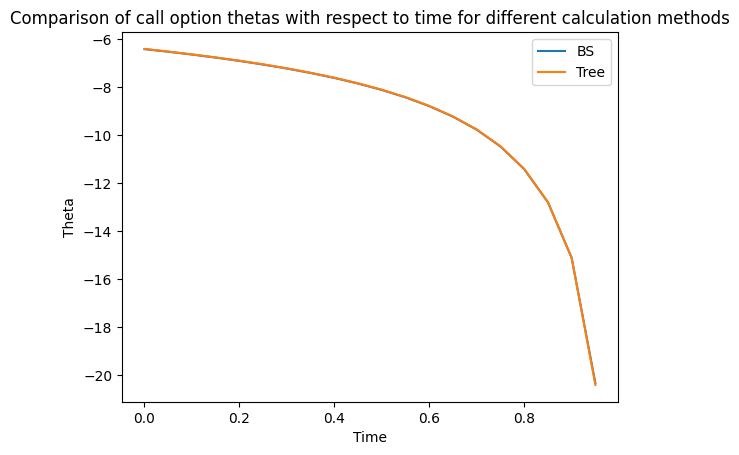

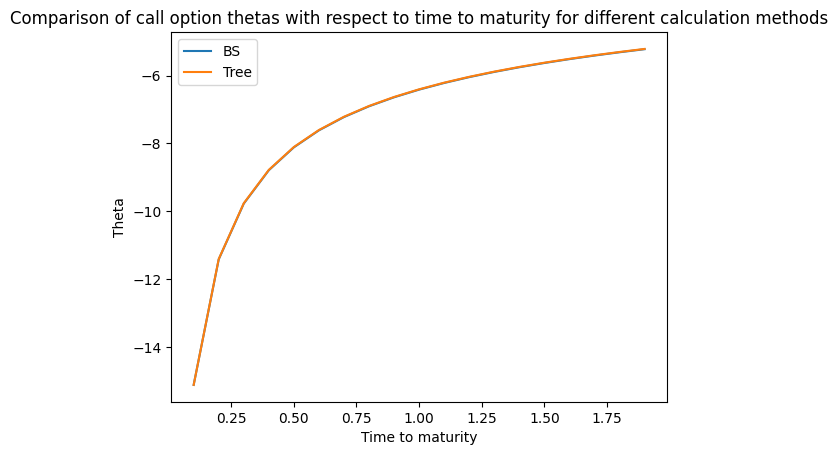

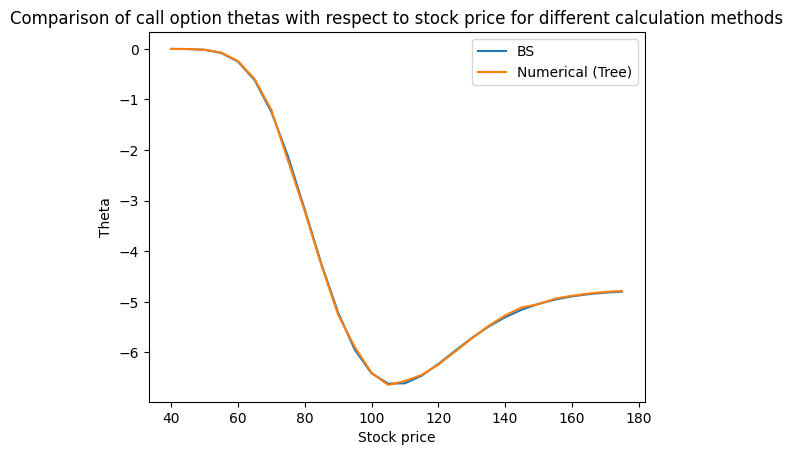

In [26]:
ts = np.arange(0,T,.05)
thetas_BS = theta_BS("call", sigma, K, T, ts, St, r,q)
thetas_tree = [theta_num("call", "European", sigma, K, T, t, St, r, q) for t in ts]

plt.plot(ts, thetas_BS, label="BS")
plt.plot(ts,thetas_tree, label="Tree")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Comparison of call option thetas with respect to time for different calculation methods")
plt.legend()
plt.show()

Ts = np.arange(.1,2,.1)
thetas_BS = theta_BS("call", sigma, K, Ts, t, St, r,q)
thetas_tree = [theta_num("call", "European", sigma, K, T, t, St, r, q) for T in Ts]

plt.plot(Ts, thetas_BS, label="BS")
plt.plot(Ts, thetas_tree, label="Tree")
plt.xlabel("Time to maturity")
plt.ylabel("Theta")
plt.title("Comparison of call option thetas with respect to time to maturity for different calculation methods")
plt.legend()
plt.show()

S = np.arange(40,180,5)
thetas_BS = theta_BS("call", sigma, K, T, t, S, r,q)
thetas_num = [theta_num("call", "European", sigma, K, T, t, St, r, q) for St in S]

plt.plot(S, thetas_BS, label="BS")
plt.plot(S, thetas_num, label="Numerical (Tree)")
plt.xlabel("Stock price")
plt.ylabel("Theta")
plt.title("Comparison of call option thetas with respect to stock price for different calculation methods")
plt.legend()
plt.show()



## Implied volatility

In [126]:
def implied_vol(call_put="call", K=100, T=1., t=0, St=100, r=.05, q=0., market_price=8, sigma_0=.3):
    """Compute the implied volatility of a call or put option using the Black-Scholes formula."""
    return fmin(lambda sigma: (Black_Scholes(call_put, sigma, K, T, t, St, r ,q)-market_price)**2, [sigma_0], disp=False)[0]
    return root(lambda sigma: Black_Scholes(call_put, sigma, K, T, t, St, r ,q)-market_price, [sigma_0])["x"][0]

0.13376953124999952

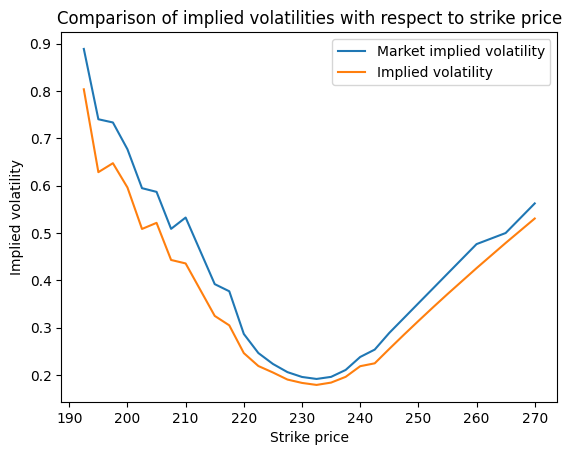

In [130]:
# Data from yahoo finance on AAPL options
strikes = [100, 105, 110, 115, 120, 125, 135, 140, 145, 150, 160, 165, 170, 175, 180, 185, 187.5, 190, 192.5, 195, 197.5, 200, 202.5, 205, 207.5, 210, 212.5, 215, 217.5, 220, 222.5, 225, 227.5, 230, 232.5, 235, 237.5, 240, 242.5, 245, 247.5, 250, 252.5, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]
bid_prices = [125.80, 120.75, 115.80, 110.75, 105.95, 89.95, 90.75, 85.80, 80.75, 75.80, 66.10, 61.25, 55.65, 51.15, 46.35, 41.60, 38.75, 36.10, 34.10, 30.95, 28.60, 26.65, 24.05, 21.65, 19.15, 16.70, 13.70, 11.75, 9.30, 6.95, 4.75, 2.91, 1.45, 0.60, 0.19, 0.06, 0.02, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
ask_prices = [127.60, 122.60, 117.55, 112.65, 107.75, 92.45, 92.55, 87.65, 82.55, 77.60, 67.50, 62.55, 56.95, 51.95, 47.60, 41.90, 39.65, 36.90, 34.55, 32.40, 29.90, 26.85, 24.35, 21.95, 19.35, 17.00, 14.45, 11.95, 9.70, 7.10, 4.85, 2.95, 1.50, 0.62, 0.21, 0.07, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
mid_prices = [(ask_price+bid_price)/2 for ask_price, bid_price in zip(ask_prices, bid_prices)]
implied_vols_market = np.array([338.67, 314.06, 296.88, 285.16, 291.60, 243.42, 214.06, 212.50, 187.50, 182.03, 166.99, 161.82, 151.95, 136.44, 127.44, 101.76, 92.29, 90.63, 88.87, 74.02, 73.34, 67.68, 59.47, 58.69, 50.88, 53.27, 45.61, 39.21, 37.70, 28.69, 24.66, 22.36, 20.63, 19.61, 19.19, 19.63, 21.09, 23.83, 25.39, 28.91, 32.03, 35.16, 38.28, 41.41, 47.66, 50.00, 56.25, 60.94, 65.63, 70.31, 75.00, 81.25, 84.38])/100

df =pd.DataFrame({"Strike":strikes, "Market price":mid_prices, "Market implied volatility":implied_vols_market})
df_filtered = df[(df["Strike"]>190) & (df["Strike"]<275)].drop(26)

df_filtered.loc[:, "Implied vol"] = [implied_vol("call", K=K, T=3/252, t=0, St=226.51, r=.04, q=0, market_price=mid_price, sigma_0=.2) for K, mid_price in zip(df_filtered["Strike"], df_filtered["Market price"])]

plt.plot(df_filtered["Strike"], df_filtered["Market implied volatility"], label="Market implied volatility")
plt.plot(df_filtered["Strike"], df_filtered["Implied vol"], label="Implied volatility")
plt.xlabel("Strike price")
plt.ylabel("Implied volatility")
plt.title("Comparison of implied volatilities with respect to strike price")
plt.legend()
plt.show()

## Online calculators
* https://accuratecalculators.com/options-calculator
* https://www.option-price.com/index.php